
Links:

https://www.youtube.com/watch?v=NSrOa4qnhvk&t=233s

https://python-binance.readthedocs.io/en/latest/

https://medium.com/swlh/retrieving-full-historical-data-for-every-cryptocurrency-on-binance-bitmex-using-the-python-apis-27b47fd8137f

https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test

https://en.wikipedia.org/wiki/Cointegration

https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient

https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient



Bibliotecas


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts 
import numpy as np
import warnings
from datetime import datetime
from binance.client import Client
from pandas_datareader import data as pdr
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller

#Ignorar mensagens de aviso:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")


Funções para extrair base de dados da Binance


In [2]:
def minutos_da_nova_data(data_inicio, simbolo, intervalo, data, corretora):
    
    '''
     Esta função tem como objetivo converter um determinado intervalo selecionado para minutos. Por exemplo:
    1h = 60m, 1d = 1440m
    
    https://medium.com/better-programming/easiest-way-to-use-the-bitmex-api-with-python-fbf66dc38633
    '''
    
    if corretora == 'binance':
        old = datetime.strptime(data_inicio, '%d %b %Y') #Ponto inicial(primeiro dia, por exemplo) da base de dados extraídas da Binance
        new = pd.to_datetime(binance_client.get_klines(symbol=simbolo, interval=intervalo)[-1][0], unit='ms') #Ponto final(ultimo dia, por exemplo) da base de dados extraídas da Binance
        
    return old, new

def data_binance(data_inicio, simbolo, intervalo):

    '''
     Esta função extrai todos os dados que queremos da corretora Binance, especialmente a data que contém
    os preços de abertura(Open), fechamento(Close), máximos(High), mínimos(Low) e volume(Volume). Além da data
    (Date) em que estamos trabalhando
    
    https://medium.com/better-programming/easiest-way-to-use-the-bitmex-api-with-python-fbf66dc38633
    '''
    
    data_df = pd.DataFrame() #Extraíndo da base da dados em formato DataFrame
    
    ponto_antigo, ponto_novo = minutos_da_nova_data(data_inicio, simbolo, intervalo, data_df, corretora = 'binance')
    
    print('Fazendo Download da base no intervalo de %s para o par de cripto %s desde %s.' % (intervalo, simbolo, data_inicio)) #Mensagem enquanto faz download dos dados
        
    dados = binance_client.get_historical_klines(simbolo, intervalo, ponto_antigo.strftime('%d %b %Y %H:%M:%S')
                                                    , ponto_novo.strftime('%d %b %Y %H:%M:%S')) #Esta função, propria da biblioteca binance.client, extrai diretamente os dados que queremos da binance

    data = pd.DataFrame(dados, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av'
                                          , 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms') #Criando coluna timestamp, formada pelas datas da data em formato pandas._libs.tslibs.timestamps.Timestamp
    
    data_df = data #Renomeando a data
    data_df.set_index('timestamp', inplace=True) #Substitui a coluna de índices pela coluna timestamp

    return data_df


Definindo base de dados target


In [3]:
binance_api_key = '' #Coloque seu API KEY dentro das aspas ''
binance_api_secret = '' #Coloque seu APy SECRET KEY dentro das aspas ''

#Intervalos de tempo:
binsizes = {'1m': 1, '3m': 3, '5m': 5, '15m': 15, '30m': 30, '1h': 60
            , '2h': 120, '4h': 240, '6h': 360, '8h': 480, '12h': 720 , '1d': 1440
            , '1w': 10080} #m representa minuto(1 minuto), h hora(60 minutos), d dia(1440 minutos) e w semana(10080)
batch_size = 250

#Função que utiliza os API's da Binance:
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret) #Não é necessário para rodar este programa

#Escolhendo os parametros para criar a base:
data_inicio = '01 Jan 2019'  #Escolha a Data de início para a criação da base de dados do par de moedas escolhido. Deve ser entre aspas e dias, meses e anos espaçados e os meses abreviados com inicial maiuscula
intervalo = '1h' #Intervalo de tempo, opções encontradas no binsizes acima
simbolos = ['BTCUSDT', 'ETHBTC', 'LINKBTC', 'BNBBTC', 'XRPBTC', 'LTCBTC', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'LTCUSDT'] #Lista de simbolos de pares de criptos da binance

pred = [] #Lista que armazena dados do passado
targ = [] #Lista que armazena dados atuais
for simbolo in simbolos:
    data = data_binance(data_inicio, simbolo, intervalo)

    passado = (pd.to_numeric(data['close']) + pd.to_numeric(data['open']) + pd.to_numeric(data['high']) + pd.to_numeric(data['low'])) / 4 #OHLC
    passado = passado.astype(float) #Passando os dados de str para float

    tamanho = 90 #Escolhendo um tamanho para a data. Neste caso, os ultimos 90 dias. Voce pode modiciar estes parametros, ou entao modificar data_inicio

    atual = passado[len(data) - tamanho:len(data)] #Base de dados que queremos fazer a predição e aplicar previsão
    atual = atual.reset_index(drop = True) #Resetando indice e dropando coluna nova de indice gerada
    passado = passado[:len(data) - tamanho] #Base de dados que será usada para predição
    passado = passado.reset_index(drop = True)
    pred.append([passado, simbolo])
    targ.append([atual, simbolo])

Fazendo Download da base no intervalo de 1h para o par de cripto BTCUSDT desde 01 Jan 2019.
Fazendo Download da base no intervalo de 1h para o par de cripto ETHBTC desde 01 Jan 2019.
Fazendo Download da base no intervalo de 1h para o par de cripto LINKBTC desde 01 Jan 2019.
Fazendo Download da base no intervalo de 1h para o par de cripto BNBBTC desde 01 Jan 2019.
Fazendo Download da base no intervalo de 1h para o par de cripto XRPBTC desde 01 Jan 2019.
Fazendo Download da base no intervalo de 1h para o par de cripto LTCBTC desde 01 Jan 2019.
Fazendo Download da base no intervalo de 1h para o par de cripto ETHUSDT desde 01 Jan 2019.
Fazendo Download da base no intervalo de 1h para o par de cripto BNBUSDT desde 01 Jan 2019.
Fazendo Download da base no intervalo de 1h para o par de cripto XRPUSDT desde 01 Jan 2019.
Fazendo Download da base no intervalo de 1h para o par de cripto LTCUSDT desde 01 Jan 2019.


Visualizando um dos dados preditivos

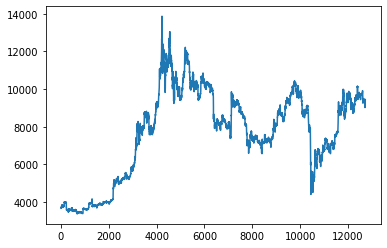

In [4]:
plt.plot(pred[0][0])


Visualizando um dos dados atuais


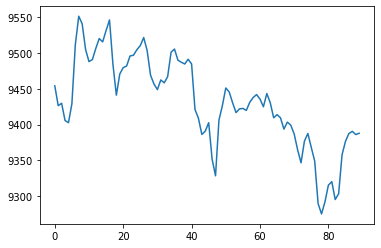

In [5]:
plt.plot(targ[0][0])


Aplicando coeficiente de Pearson nas bases de dados do passado e a atual


In [6]:
#Fazemos aqui uma combinação entre os pares de criptos e buscamos registramos todos os coeficientes de Pearson encontrados
p = []
for base1 in pred:
    for base2 in targ:
        for i in range(0,len(passado) - len(atual) - 1):
            passado1 = base1[0][i:i + len(atual)] #Cada pedaço de gráfico para cada i no range acima

            pearson_coeficiente = pearsonr(passado1 , base2[0]) #Coeficiente de Pearson aplicado nos preços de fechamento do BTC e S&P(cada pedaço), ambos variando de 0 a 1
            '''
            Caso queira utilizar o coeficiente de Spearman, troque a função pearsonr() acima por spearmanr()
            Ou, caso queira utilizar o coeficiente de Kendall, utilize a função kendalltau()
            '''
            #print('Preditiva: %s // Target: %s // i = %s // p = %s' %(base1[1], base2[1], i, pearson_coeficiente[0])) #Print do coeficiente de Pearson com seu indice respectivo
            p.append([pearson_coeficiente[0], base1[1], base2[1], i]) #Lista dos coeficientes de Pearson, pares de criptos do passado e atual e indice


Visualizando indice com melhor performace


In [7]:
max(p) #Maior coeficiente de correlação
indice = p.index(max(p)) #Indice na qual se encontra o maior coeficiente de correlação
print("Preditiva: %s // Target: %s // Coeficiente de Pearson: %s // Indice: %s" %(p[indice][1], p[indice][2], p[indice][0], p[indice][3]))

Preditiva: LINKBTC // Target: LINKBTC // Coeficiente de Pearson: 0.9684911132131875 // Indice: 10187



Porém, encontrar o melhor coeficiente na correlação não basta. Precisamos também verificar a cointegração. Caso os residuos da combinação linear entre as bases
escolhidas não sejam estacionarios, escolhemos então outra correlação, até encontrarmos uma que seja cointegrada.


In [8]:
for i in range(len(passado)):
    indice = p.index(max(p)) #Indice na qual se encontra o maior coeficiente de correlação
    
    for i in range(len(pred)):
        if p[indice][1] in pred[i][1]:
            pred_X = pred[i][0]
        if p[indice][2] in targ[i][1]:
            targ_Y = targ[i][0]
    
    #Formatando os dados para podemos utilizar a regressão linear:
    X = pred_X[p[indice][3]:p[indice][3] + len(atual)]
    X = X.reset_index(drop = True)
    X = np.array(X).reshape(-1,1)
    Y = targ_Y.reset_index(drop = True)
    Y = np.array(Y).reshape(-1,1)
    
    modelo = LinearRegression().fit(X, Y) #modelo de regressão linear
    residuos = modelo.predict(X) - Y #Resíduos da regressão linear
    
    teste_DF = adfuller(residuos) #Teste de estacionaridade de Dickey-Fuller
    
    if teste_DF[1] <= 0.05: #Caso seja estacionária, o laço se encerra
        break
    else:
        p[indice][0] = 0 #Caso não seja estacionário, tentamos encontrar outros índices


Plotando resíduos da melhor correlação encontrada que também é correladionada e visualizando p-valor(que deve ser <= 0.05):


P-valor = 0.000124 <= 0.05 // Residuos estacionários


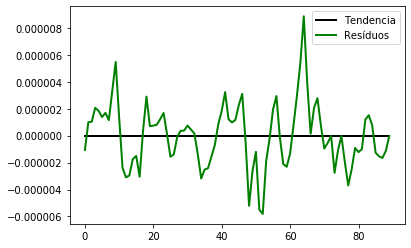

In [9]:
modelo_residuo = LinearRegression().fit(X, residuos)
reta = modelo_residuo.intercept_ + modelo_residuo.coef_ * X

plt.plot(reta, linewidth = 2, color = 'black', label = 'Tendencia')
plt.plot(residuos, linewidth = 2, color = 'green', label = 'Resíduos')
plt.legend()
print("P-valor = %s <= 0.05 // Residuos estacionários" %round(teste_DF[1],6))


Plotando base de dados atual e pedaço de dados do passado com melhor correlação e cointegração:


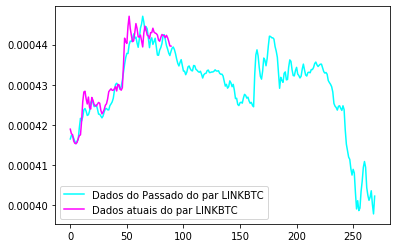

In [10]:
dias = 180  #Dias depois da base de dados de fechamento do S&P com melhor coeficiente de correlação, voce pode modificar isto

#Extraindo as bases de predição e target usando o melhor indice
for i in range(len(pred)):
    if p[indice][1] in pred[i][1]:
        pred_X = pred[i][0]
    if p[indice][2] in targ[i][1]:
        targ_Y = targ[i][0]

#Extraindo os dados do passado, pelo indice descoberto acima, que se correlacionaram com os dados atuais
X = pred_X[p[indice][3]:p[indice][3] + len(atual) + dias]
X = X.reset_index(drop = True)
Y = targ_Y.reset_index(drop = True)

#Plotando resultados em uma escala na qual os dados ficam bem proximos, afim de gerar uma visualização melhor do forecasting
plt.plot((X - min(X[:len(Y)])) * ((max(Y) - min(Y)) / (max(X[:len(Y)]) - min(X[:len(Y)]))) + min(Y) , label = "Dados do Passado do par %s" %(p[indice][1]), color = 'cyan')
plt.plot(Y , label = "Dados atuais do par %s" %(p[indice][2]), color = 'magenta')
plt.legend() #Ativando legendas